# Reinforcement Learning with Replacing Eligibility Traces

Final project for **Stochastic Methods in Mathematical Modeling**

Student: Akhtyamov Timur

In [55]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)

## Experiment 1: Random-Walk

In [34]:
N_STATES = 21
START_STATE = 11
LEFT_ABSORBING_STATE = 1
RIGHT_ABSORBING_STATE = 21
LEFT_ABSORBING_REWARD = -1
RIGHT_ABSORBING_REWARD = 1

GT_STATE_VALUES = np.array([-1] + [(n - 11) / 10 for n in range(2, 21)] + [1])

In [23]:
def sample_random_walks(n_samples):
    samples = []
    directions = [1, -1]
    for _ in range(n_samples):
        current_state = 11
        states = [current_state]
        rewards = []
        while current_state not in [LEFT_ABSORBING_STATE, RIGHT_ABSORBING_STATE]:
            current_state = current_state + np.random.choice(directions)
            states.append(current_state)
            if current_state == LEFT_ABSORBING_STATE:
                rewards.append(LEFT_ABSORBING_REWARD)
            elif current_state == RIGHT_ABSORBING_STATE:
                rewards.append(RIGHT_ABSORBING_REWARD)
            else:
                rewards.append(0)
        samples.append((np.array(states), np.array(rewards)))
    return samples

In [33]:
rw = sample_random_walks(1)[0]
print(rw[0].shape, rw[1].shape)

(179,) (178,)


In [40]:
MODE_ACC = "acc"
MODE_REPLACE = "replace"

def td_lambda(random_walk, rewards, lmbda, alpha, mode):
    value_estimates = np.zeros(N_STATES)
    traces = np.zeros(N_STATES)
    
    for t, state in enumerate(random_walk):
        # Common factor
        reward = rewards[t] if t != len(random_walk)-1 else 0
        current_value = value_estimates[state - 1]
        next_value = value_estimates[random_walk[t+1] - 1] if t != len(random_walk)-1 else 0
        factor = alpha * (reward + next_value - current_value)
        
        # Update traces
        traces = lmbda * traces
        if mode == MODE_ACC:
            traces[state - 1] += 1
        elif mode == MODE_REPLACE:
            traces[state - 1] = 1
        
        # Update value estimates
        value_estimates = value_estimates + factor * traces
        
    return value_estimates

In [79]:
def random_walk_experiment(random_walk_samples, lmbdas, alphas, mode):
    lmbdas_rmses = []
    for lmbda in lmbdas:
        rmses = []
        for alpha in alphas:
            alpha_rmses = []
            for i in range(len(random_walk_samples)):
                random_walk, rewards = random_walk_samples[i]
                value_estimates = td_lambda(random_walk, rewards, lmbda=lmbda, alpha=alpha, mode=mode)
                rmse = np.sqrt(np.mean((value_estimates - GT_STATE_VALUES) ** 2))
                alpha_rmses.append(rmse)
            rmses.append(np.mean(alpha_rmses))
        lmbdas_rmses.append(rmses)
    return np.array(lmbdas_rmses)

In [ ]:
random_walk_samples = sample_random_walks(10)

In [80]:
lmbdas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975, 0.99, 1.0]
alphas = np.linspace(0.0, 1.0, 100)

rmses_acc = random_walk_experiment(random_walk_samples, lmbdas, alphas, MODE_ACC)
rmses_replace = random_walk_experiment(random_walk_samples, lmbdas, alphas, MODE_REPLACE)

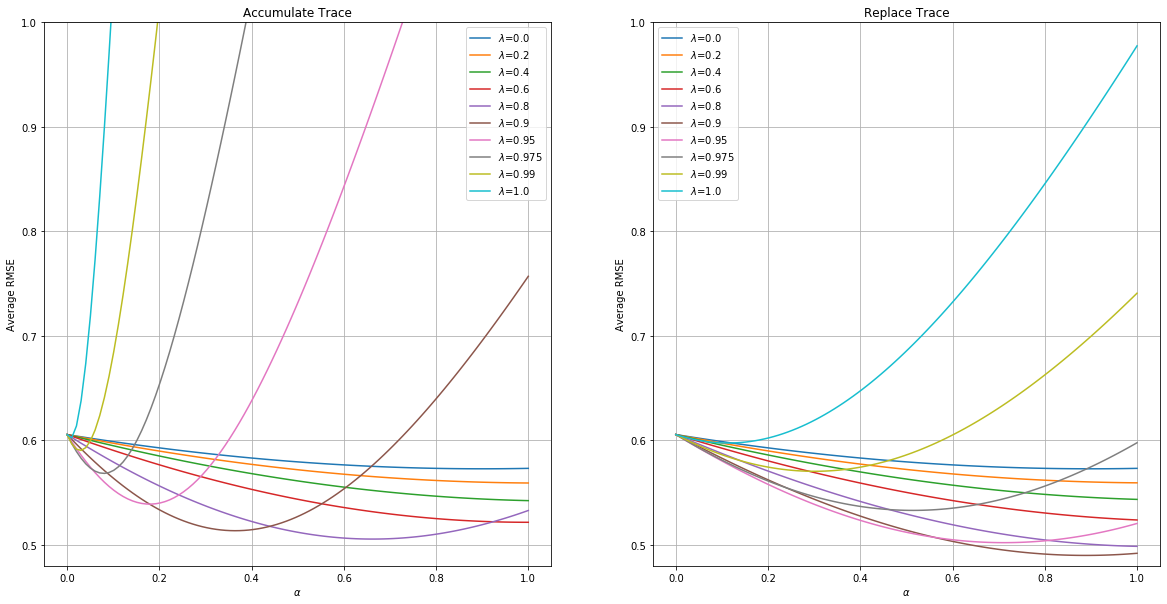

In [87]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1.set_ylim(0.48, 1.0)
ax2.set_ylim(0.48, 1.0)

for i, lmbda in enumerate(lmbdas):
    ax1.plot(alphas, rmses_acc[i], label="$\\lambda$=" + str(lmbda))
    ax2.plot(alphas, rmses_replace[i], label="$\\lambda$=" + str(lmbda))
    
ax1.set_title("Accumulate Trace")
ax2.set_title("Replace Trace")
for ax in [ax1, ax2]:
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("Average RMSE")
    ax.grid()
    ax.legend()
    
plt.show()

In [91]:
best_acc = np.min(rmses_acc, axis=1)
best_replace = np.min(rmses_replace, axis=1)

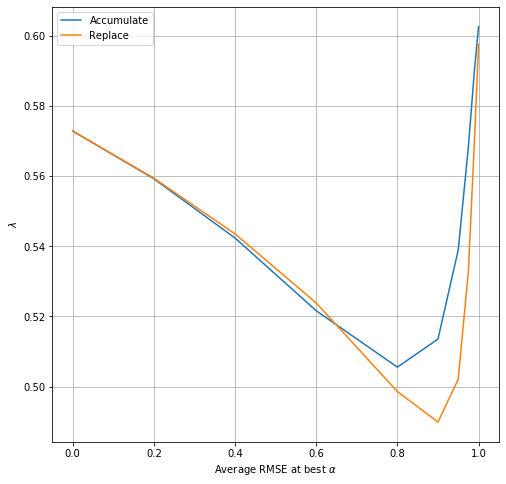

In [94]:
plt.figure(figsize=(8, 8))

plt.plot(lmbdas, best_acc, label="Accumulate")
plt.plot(lmbdas, best_replace, label="Replace")

plt.xlabel("Average RMSE at best $\\alpha$")
plt.ylabel("$\\lambda$")
plt.grid()
plt.legend()
plt.show()